In [ ]:
!pip install scikit-image

In [1]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import os
import random
import shutil
from IPython.display import HTML, display

In [2]:
# Function for categorizing images as Foggy/Hazy
def detect_fog(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and enhance fog features
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Compute the absolute difference between the original and blurred images
    diff = cv2.absdiff(gray, blurred)

    # Threshold the difference image to identify foggy regions
    _, fog_mask = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)

    # Additional features for fog detection
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    mean_blur = cv2.mean(blurred)[0]

    # Adjust the fog detection based on mean intensity, standard deviation, and mean blur
    is_foggy = (
        mean_intensity > 100 and
        std_intensity < 20 and
        mean_blur < 90 and
        np.sum(fog_mask == 255) / fog_mask.size > 0.1
    )

    return is_foggy

# Function for categorizing images as Snowy
def detect_snow(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define a range for snow color in HSV
    lower_snow = np.array([0, 0, 180], dtype=np.uint8)
    upper_snow = np.array([180, 25, 255], dtype=np.uint8)

    # Create a mask to extract the lower vegetation part
    height, width, _ = image.shape
    lower_vegetation_mask = np.zeros((height, width), dtype=np.uint8)
    lower_vegetation_mask[int(height / 2):, :] = 255

    # Apply the mask to the HSV image
    hsv_lower_vegetation = cv2.bitwise_and(hsv, hsv, mask=lower_vegetation_mask)

    # Create a mask for snow in the lower vegetation part
    snow_mask = cv2.inRange(hsv_lower_vegetation, lower_snow, upper_snow)

    # Use morphology to enhance snow regions
    kernel = np.ones((5, 5), np.uint8)
    snow_mask = cv2.morphologyEx(snow_mask, cv2.MORPH_CLOSE, kernel)

    # Calculate the percentage of the lower vegetation covered by snow
    snowy_percentage = np.sum(snow_mask == 255) / snow_mask.size

    return snowy_percentage > 0.1  # Adjust the threshold as needed

# Function for categorizing images as Blurred
def detect_blurred_phenocam(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the Laplacian of the image to detect edges
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Calculate the variance of the Laplacian
    laplacian_var = laplacian.var()

    # Apply a threshold to detect blurred images
    is_blurred = laplacian_var < 1000  # Adjust the threshold as needed

    return is_blurred

# Function for categorizing images as Darken
def categorize_darken(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the mean and standard deviation of pixel intensities
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)

    # Additional conditions for nighttime detection
    is_dark_mean = mean_intensity < 70
    is_low_contrast = std_intensity < 30

    return is_dark_mean and is_low_contrast


In [3]:
# Function to check if an image is categorized as specific category
def is_image_in_category(image_path, category_function):
    try:
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Skipping {image_path} - Unable to load image.")
            return False, None

        is_in_category = category_function(original_image)
        return is_in_category, original_image

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return False, None

# Select all available .jpg images
all_images = []
for root, _, files in os.walk("Images"):
    for file in files:
        if file.lower().endswith(".jpg"):
            all_images.append(os.path.join(root, file))

# Categories
categories = {
    "Darken": categorize_darken,
    "Foggy": detect_fog,
    "Snowy": detect_snow,
    "Blurred": detect_blurred_phenocam,
}

# Iterate to find at least one "Correct" image from each category
for category_name, category_function in categories.items():
    found_correct_image = False
    iterations = 0
    max_iterations = 100  # Adjust the maximum number of iterations if needed

    while not found_correct_image and iterations < max_iterations:
        random_images = random.sample(all_images, 10)
        found_correct_image = any(is_image_in_category(img_path, category_function)[0] for img_path in random_images)
        iterations += 1

    if found_correct_image:
        # Visualize and annotate the selected images
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle(f"Random 10 {category_name} Images")

        for i, img_path in enumerate(random_images):
            is_in_category, original_image = is_image_in_category(img_path, category_function)

            annotation = 'Correct' if is_in_category else 'Incorrect'
            axes[i // 5, i % 5].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            axes[i // 5, i % 5].axis('off')
            axes[i // 5, i % 5].set_title(annotation, color='green' if is_in_category else 'red')

        plt.show()
    else:
        print(f"No correct image found for {category_name} after {iterations} iterations.")

No correct image found for Darken after 100 iterations.
No correct image found for Foggy after 100 iterations.
No correct image found for Snowy after 100 iterations.
No correct image found for Blurred after 100 iterations.


In [7]:
# Function to move images to specific folders based on category detection
def move_images_based_on_category(image_folder, output_folder_dict):
    for category_name, output_folder in output_folder_dict.items():
        for root, dirs, files in os.walk(image_folder):
            for file in files:
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(root, file)
                    original_image = cv2.imread(img_path)

                    if original_image is not None:
                        if category_name == "Darken":
                            is_in_category = categorize_darken(original_image)
                        elif category_name == "Snowy":
                            is_in_category = detect_snow(original_image)
                        elif category_name == "Blurred":
                            is_in_category = detect_blurred_phenocam(original_image)
                        elif category_name == "Foggy":
                            is_in_category = detect_fog(original_image)
                        else:
                            # Handle other categories if needed
                            is_in_category = False
                        
                        if is_in_category:
                            # Move the image to the corresponding output folder
                            shutil.move(img_path, os.path.join(output_folder, file))

# Define folders
image_folder = "Images"
output_folder_dict = {
    "Darken": "DarkenImages",
    "Snowy": "SnowyImages",
    "Blurred": "BlurredImages",
    "Foggy": "FoggyImages",
}

# Create output folders if they don't exist
for output_folder in output_folder_dict.values():
    os.makedirs(output_folder, exist_ok=True)

In [8]:
# Apply the algorithms and move images
move_images_based_on_category(image_folder, output_folder_dict)

KeyboardInterrupt: 

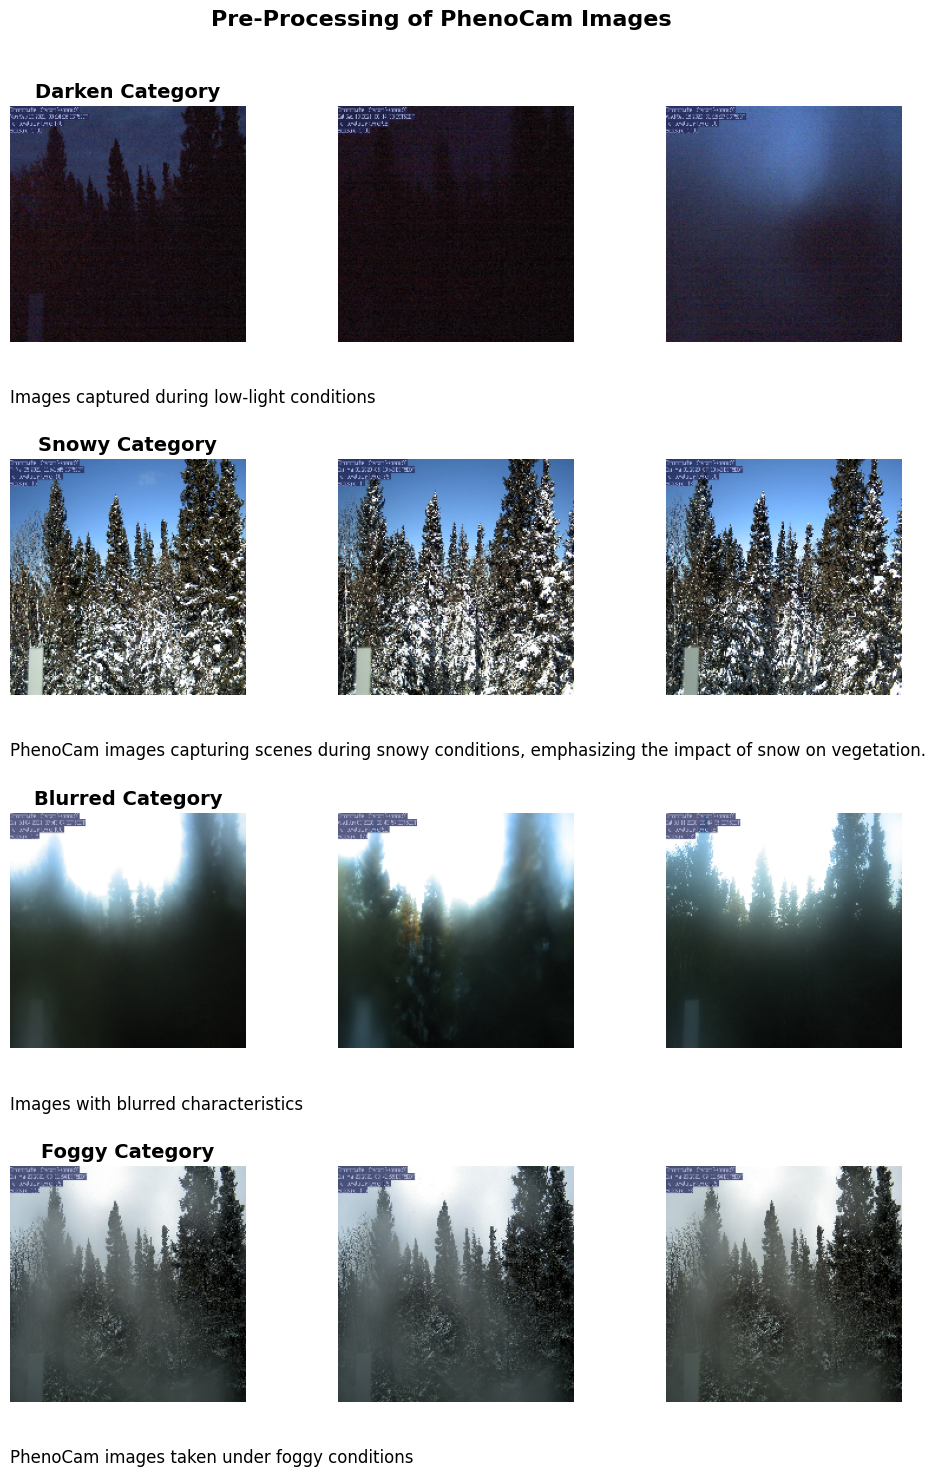

In [11]:
# Function to load and resize an image
def load_and_resize_image(image_path, target_size=(200, 200)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, target_size)

# Function to create a combined plot for the research paper
def create_combined_plot(image_folder_dict, category_descriptions, save_path=None):
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    fig.suptitle("Pre-Processing of PhenoCam Images", fontsize=16, weight='bold')

    for i, (category_name, image_folder) in enumerate(image_folder_dict.items()):
        # Get all images from each category
        category_images = os.listdir(image_folder)
        
        # If there are fewer than 3 images, display all; otherwise, select 3 random images
        if len(category_images) <= 3:
            selected_images = category_images
        else:
            selected_images = random.sample(category_images, 3)

        for j, image_name in enumerate(selected_images):
            image_path = os.path.join(image_folder, image_name)
            image = load_and_resize_image(image_path)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')

        axes[i, 0].set_title(f"{category_name} Category", fontsize=14, weight='bold')
        axes[i, 0].text(0, -0.2, category_descriptions[category_name], transform=axes[i, 0].transAxes,
                       fontsize=12, ha='left', va='top', wrap=True)

    plt.subplots_adjust(top=0.92, hspace=0.5)  # Adjust the top and hspace for better spacing
    
    # Save the plot in full HD quality if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
    # Display a download link
    if save_path:
        display(HTML(f'<a href="{save_path}" download>Click here to download the plot</a>'))

# Define image folders and category descriptions
image_folder_dict = {
    "Darken": "DarkenImages",
    "Snowy": "SnowyImages",
    "Blurred": "BlurredImages",
    "Foggy": "FoggyImages",
}

category_descriptions = {
    "Darken": "Images captured during low-light conditions",
    "Snowy": "PhenoCam images capturing scenes during snowy conditions, emphasizing the impact of snow on vegetation.",
    "Blurred": "Images with blurred characteristics",
    "Foggy": "PhenoCam images taken under foggy conditions",
}

# Specify the save path
save_path = "combined_plot_full_hd.png"

# Create and display the beautiful plot, and save it if specified
create_combined_plot(image_folder_dict, category_descriptions, save_path)

# c .